# CIFAR-10 Vision Transformer

Training a ViT model on CIFAR-10 dataset and using a pre-trained ViT for improving accuracy.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from transformers import ViTModel
from torchvision import models

## Implementation of ViT

Multi-head attention module

In [ ]:
class MultiheadAttentionEinsum(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiheadAttentionEinsum, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        assert embedding_dim % num_heads == 0
        self.q_linear = nn.Linear(embedding_dim, embedding_dim)
        self.k_linear = nn.Linear(embedding_dim, embedding_dim)
        self.v_linear = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value):
        batch_size = query.shape[0]
        # Linear projections
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        # Scaled dot-product attention
        scores = torch.einsum('bnqd,bnkd->bnqk', Q, K) / (self.head_dim ** 0.5)
        attention = torch.softmax(scores, dim=-1)
        # Attended values
        attended_values = torch.einsum('bnqk,bnvd->bnqd', attention, V).transpose(1, 2)
        attended_values = attended_values.reshape(batch_size, -1, self.num_heads * self.head_dim)
        # Final linear projection
        out = self.fc_out(attended_values)
        return out

Encoder layer

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(TransformerEncoderLayer, self).__init__()
        self.multihead_attention = MultiheadAttentionEinsum(embed_dim=embedding_dim, num_heads=num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, embedding_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = x.permute(1, 0, 2)
        attn_output = self.multihead_attention(x, x, x)[0]
        x = attn_output + residual
        x = x.permute(1, 0, 2)
        residual = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = x + residual
        return x

The whole model

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, patch_size, embedding_dim, num_heads, num_layers):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(3, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, 14 * 14 + 1, embedding_dim))
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat((x, self.positional_encoding.repeat(batch_size, 1, 1)), dim=1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hyperparameters

In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001
num_classes = 10
patch_size = 16
embedding_dim = 128
num_heads = 8
num_layers = 3

Loading and preprocessing dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Building the model

In [ ]:
model = VisionTransformer(num_classes, patch_size, embedding_dim, num_heads, num_layers).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training loop

In [ ]:
total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/782], Loss: 2.1743
Epoch [1/10], Step [200/782], Loss: 2.2628
Epoch [1/10], Step [300/782], Loss: 2.0070
Epoch [1/10], Step [400/782], Loss: 2.0852
Epoch [1/10], Step [500/782], Loss: 2.0053
Epoch [1/10], Step [600/782], Loss: 2.0632
Epoch [1/10], Step [700/782], Loss: 1.8688
Epoch [2/10], Step [100/782], Loss: 1.9895
Epoch [2/10], Step [200/782], Loss: 2.0050
Epoch [2/10], Step [300/782], Loss: 2.1289
Epoch [2/10], Step [400/782], Loss: 2.0359
Epoch [2/10], Step [500/782], Loss: 2.0502
Epoch [2/10], Step [600/782], Loss: 1.9462
Epoch [2/10], Step [700/782], Loss: 2.0446
Epoch [3/10], Step [100/782], Loss: 2.0215
Epoch [3/10], Step [200/782], Loss: 2.0119
Epoch [3/10], Step [300/782], Loss: 1.9910
Epoch [3/10], Step [400/782], Loss: 2.0592
Epoch [3/10], Step [500/782], Loss: 2.0573
Epoch [3/10], Step [600/782], Loss: 1.9202
Epoch [3/10], Step [700/782], Loss: 2.0267
Epoch [4/10], Step [100/782], Loss: 2.0055
Epoch [4/10], Step [200/782], Loss: 2.1177
Epoch [4/10

Evaluation and accuracy

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')

Test Accuracy of the model on the 10000 test images: 38.99%


---
Here we change and test hyperparameters to get better results.

It is also notable that we could not run a heavy model due to colab's limitations.


Overall changes
* Higher value for number of epochs
* Increased batch size and number of layers
* Reduced embedding dim and number of heads

In [ ]:
num_epochs = 20
batch_size = 256
learning_rate = 0.001
num_classes = 10
patch_size = 16
embedding_dim = 64
num_heads = 4
num_layers = 4

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = VisionTransformer(num_classes, patch_size, embedding_dim, num_heads, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_steps = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/20], Step [100/196], Loss: 2.1333
Epoch [2/20], Step [100/196], Loss: 1.9316
Epoch [3/20], Step [100/196], Loss: 1.8236
Epoch [4/20], Step [100/196], Loss: 1.6120
Epoch [5/20], Step [100/196], Loss: 1.6060
Epoch [6/20], Step [100/196], Loss: 1.4951
Epoch [7/20], Step [100/196], Loss: 1.4209
Epoch [8/20], Step [100/196], Loss: 1.2905
Epoch [9/20], Step [100/196], Loss: 1.3277
Epoch [10/20], Step [100/196], Loss: 1.2982
Epoch [11/20], Step [100/196], Loss: 1.3345
Epoch [12/20], Step [100/196], Loss: 1.2371
Epoch [13/20], Step [100/196], Loss: 1.1746
Epoch [14/20], Step [100/196], Loss: 1.1767
Epoch [15/20], Step [100/196], Loss: 1.1174
Epoch [16/20], Step [100/196], Loss: 0.9692
Epoch [17/20], Step [100/196], Loss: 1.1116
Epoch [18/20], Step [100/196], Loss: 1.1323
Epoch [19/20], Step [100/196], Loss: 0.9683
Epoch [20/20], Step [100/196], Loss: 1.0162


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')

Test Accuracy of the model on the 10000 test images: 62.17%


---
## Pre-Trained Vision Transformer
There is also a built-in version of ViT model which was trained on ImageNet-21k at resolution 224 * 224. Here we try this model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 42503736.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Freezing params

In [ ]:
for param in vit_model.parameters():
      param.requires_grad = False

Designing the network

In [ ]:
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=10):
        super(ViTForImageClassification, self).__init__()
        self.vit = vit_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)
        return logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = ViTForImageClassification()
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3

Training loop

In [ ]:
total_steps = len(train_loader)
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/3], Step [100/196], Loss: 0.3800
Epoch [2/3], Step [100/196], Loss: 0.1560
Epoch [3/3], Step [100/196], Loss: 0.1324


Even after 3 epochs, the result was amazing in comparison to the previous model.

Evaluation and test

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')

Test Accuracy of the model on the 10000 test images: 96.10%


In [ ]:
torch.save(model.state_dict(), 'pre-trained ViT.pth')

---
## Pre-Trained CNNs
Here we compare the result of the last past with one of the pre-trained CNN models.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Here we used ResNet18

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3

In [ ]:
total_steps = len(train_loader)
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch [1/3], Step [100/196], Loss: 0.3257
Epoch [2/3], Step [100/196], Loss: 0.1958
Epoch [3/3], Step [100/196], Loss: 0.0993


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the {total} test images: {accuracy:.2f}%')

Test Accuracy of the model on the 10000 test images: 89.34%


ViT was better than ResNet18 although ResNet18 had a better result on training set.

This means that vision transformers are more generalized than CNNs

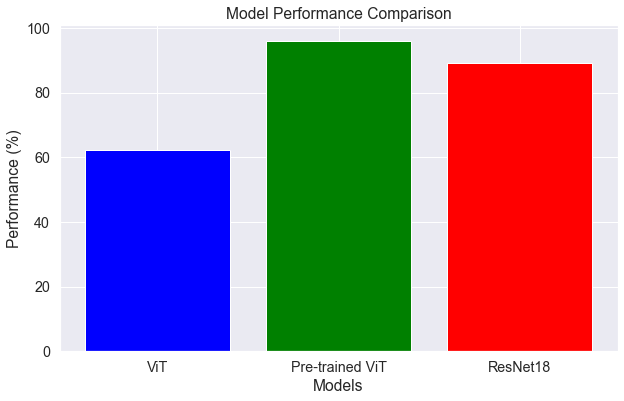

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['ViT', 'Pre-trained ViT', 'ResNet18']
values = [62.17, 96.1, 89.34]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, values, color=['blue', 'green', 'red'])

# Add titles and labels
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Performance (%)')

# Show the plot
plt.show()
